# Local learning rules to attenuate forgetting in neural networks
This demo should guide you through the basic steps of the algorithm used in our paper. We are thereby especially aiming to reproduce the key figure 3b, which represents the forgetting of patterns in continuous learning.

## Set up Framework
We fist set up our framework. We load the parameters needed for our plots, load our classes and libraries and define helper functions.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Define the parameters for our plots such as label sizes
%run -i '../code/define_plotting_framework.py'

# Create to_triangular(), from_triangular(), dice_coefficient() and evaluate_stability()
%run -i '../code/define_helper_functions.py'

## Define Hyperparameters
We now define the hyperparameters. Their function is given in the code comments.

In [2]:
ETA = 0.1  # learning rate
SPARSITY = 0.1  # number of zeros: SPARSITY = 0.1 means 10% ones and 90% zeros
IMAGE_SIZE = 10  # the size of our pattern will be (IMAGE_SIZE x IMAGE_SIZE)
TRIALS = 10  # number of trials over which the results will be averaged

epochs_patterns_presented = 5 # number of epochs a single pattern is presented
n_stored_patterns = 0 # number of instantaneously stored patterns in our network at the beginning of learning
n_new_patterns = 10 # number of continuously stored patterns in our network
eval_epochs = 10 # checking stability of patterns after eval_epochs iterations

n_tot_patterns = n_stored_patterns + n_new_patterns
NTRAIN = epochs_patterns_presented * n_new_patterns

## Choose Learning
Setting these parameters to True will lead to an evaluation of the respective method. False will discard the method.

In [3]:
# Set methods to True is they should be evaluated, to False for discarding
USE_HOPFIELD = True # classical Hebbian Learning rule for Hopfield networks
USE_EXPONENTIAL = False # exponential rule
USE_EXPONENTIAL_THRESHOLD = False # exponential rule with threshold
USE_BAYES = False # bayesian with first order polynomial
USE_BAYES_POW = False # bayesian with second order polynomial
USE_BAYES_THRESHOLD = False # bayesian with threshold
USE_W_THRESHOLD = False # weight threshold

## Initialize network
We define our network, the patterns and the mean-free patterns. We then initialize the network.

In [4]:
# preparing patterns
solver = solverClass()
patterns = solver.create_patterns(SPARSITY, IMAGE_SIZE, n_tot_patterns)
netFisher = hopfieldNet(IMAGE_SIZE, ETA, SPARSITY)
original_patterns = copy.deepcopy(patterns)
patterns = patterns - SPARSITY

# creating an empty weight matrix. Will be filled in the next lines
p = np.zeros(shape=(IMAGE_SIZE**2, IMAGE_SIZE**2))    

if n_stored_patterns>0: # initialize weight matrix with n_stored_patterns
    for i in range(n_stored_patterns):
        p += np.outer(patterns[:, i], patterns[:, i])
        netFisher.append_pattern(patterns[:, i], NTRAIN)
    w1 = p/n_stored_patterns
else: # initialize the network with other patterns that will not be considered for the evaluation
    ns = 20
    pre_patterns = solver.create_patterns(SPARSITY, IMAGE_SIZE, ns) - SPARSITY
    for i in range(ns):
        p += np.outer(pre_patterns[:, i], pre_patterns[:, i])
    w1 = p/ns/1
netFisher.set_weights(w1)

## Define evaluation functions
We set up the functions needed for calculating the Dice-coefficient. We evaluate all patterns and store their Dice-coefficients.

In [5]:
def compute_dice(ETA, c, t, func):#, t = 0.0):
    wF = np.copy(w1)
    DICE = -np.ones(shape=(NTRAIN, n_tot_patterns))
    N_PRE = 0
    NTRAIN_PRE = epochs_patterns_presented * N_PRE  # number of epochs
    pre_patterns = solver.create_patterns(SPARSITY, IMAGE_SIZE, N_PRE)

    all_patterns = np.hstack((pre_patterns - SPARSITY,patterns))
    w_mean = np.zeros(NTRAIN+NTRAIN_PRE)
    for epoch in range(NTRAIN+NTRAIN_PRE):
        id_pattern_taught = n_stored_patterns+epoch//epochs_patterns_presented
        pattern_taught = all_patterns[:, id_pattern_taught]

        z = (np.outer(pattern_taught, pattern_taught) - wF)

        perturbation_vector = func(wF, c, np.abs(z), t) * z * ETA
        wF = wF + perturbation_vector
        netFisher.set_weights(wF)
        w_mean[epoch] = np.mean(wF)

        # checking stability of patterns after eval_epochs iterations
        if epoch>=NTRAIN_PRE:
            DICE[epoch-NTRAIN_PRE] = evaluate_stability(  # old patterns
                netFisher, original_patterns.T[:n_tot_patterns], average=False)
    return DICE

def compute_dice_error(par,args):
    if len(par)==3:
        ETA, c, t = par
    elif len(par)==2:
        ETA, c, t = par[0], par[1], 0
    else:
        ETA, c, t = par[0], 0, 0
    return -np.sum(compute_dice(ETA, c, t, args)>0.9)

## Optimize Parameters
We choose the learning rule(s) to be used and evaluate and optimize their parameters.

In [6]:
%%time
from scipy.optimize import minimize
from scipy import optimize

# These are the possible functions we can use
expo = lambda wF, c, z, t: np.exp(-c*np.abs(wF))
bayes = lambda wF, c, z, t: c/(c+np.abs(wF))
bayes_pow = lambda wF, c, z, t: c/(c+np.abs(wF)*(1-np.abs(wF)))
bayes_thres = lambda wF, c, z, t: c/(c+np.abs(wF))*(z>t)
w_thres  = lambda wF, c, z, t: wF<c
hopfield  = lambda wF, c, z, t: np.ones(wF.shape)
expo_thres = lambda wF, c, z, t: np.exp(-c*np.abs(wF))*(z>t)

# use the scipy inbuilt function optimize.fmin() to optimize the parameters of our learning rule
%run -i '../code/optimize.py'

print(parameters) # parameters of the optimization

Optimization terminated successfully.
         Current function value: -137.000000
         Iterations: 10
         Function evaluations: 26
[array([0.08])]
CPU times: user 1.73 s, sys: 25.3 ms, total: 1.75 s
Wall time: 1.77 s


## Run Network
We are now going to run our network with the optimized set of parameter obtained above.

In [7]:
# create dictionary that will store the data
%run -i '../code/create_data_dictionary.py'

# loop over trials over which will later on be averaged
for i in range(TRIALS):

    patterns = solver.create_patterns(SPARSITY, IMAGE_SIZE, n_tot_patterns)
    original_patterns = copy.deepcopy(patterns)
    patterns = patterns - SPARSITY
    
    num_iteration = 0
    for key in data.keys():
        
        c = parameters[order_dict[key]]

        if key == 'hopfield':
            data['hopfield'].append(compute_dice(c[0], 0, 0, hopfield))

        if key == 'exponential':
            data['exponential'].append(compute_dice(c[0], c[1], 0, expo))

        if key == 'exponenital_thr':
            data['exponenital_thr'].append(compute_dice(c[0], c[1], c[2], expo_thres))

        if key == 'bayes':
            data['bayes'].append(compute_dice(c[0], c[1], 0, bayes))

        if key == 'bayes_pow':
            data['bayes_pow'].append(compute_dice(c[0], c[1], 0, bayes_pow))

        if key == 'bayes_thr':
            data['bayes_thr'].append(compute_dice(c[0], c[1], c[2], bayes_thres))
            
        if key == 'w_thr':
            data['w_thr'].append(compute_dice(c[0], c[1], 0, w_thres))
            
        num_iteration += 1

## Plot results

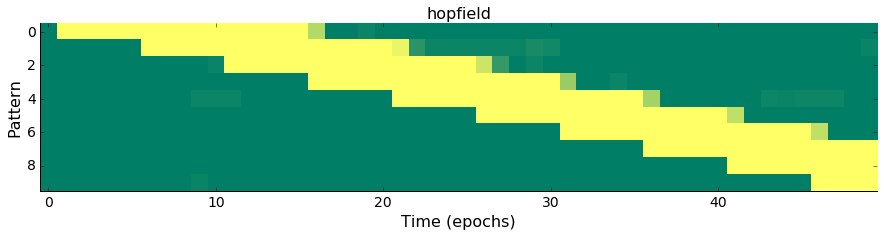

In [8]:
fig = plt.figure(figsize=(15, 3*num_evaluations))
plot_number = 1

for key in data.keys():
        
    ax = plt.subplot(num_evaluations, 1, plot_number)
    
    ax.set_title(key)

    center = np.mean(data[key], axis=0)
    
    # print(np.mean(center))
    n,m = center.shape
    im = ax.imshow(center.T,cmap=plt.cm.summer,aspect=0.2*n/m,vmin=0,vmax=1)
    
    if plot_number == 1:
        #plt.colorbar(ax)
        #ax.colorbar(im)
        #cbaxes = ax.add_axes([0.1, 0.1, 0.03, 0.8])
        ax.set_ylabel('Pattern')

    if plot_number == num_evaluations:
        ax.set_xlabel('Time (epochs)')
    plot_number += 1